In [ ]:
import cv2 # working with, mainly resizing, images
import numpy as np # dealing with arrays
import os # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training .
from tqdm import tqdm # a nice pretty percentage bar for tasks.

In [22]:
Train_Dir = 'E:/catsvsdogs/train/train'
Test_Dir = 'E:/catsvsdogs/test1/test1'
IMG_SIZE = 50
LR = 1e-3
MODEL_NAME = 'catsvsdogs-{}-{}.model'.format(LR, '2conv-basic') # Just so we remember which saved model is which, sizes must match

Now, our first order of business is to convert the images and labels to array infomation that we can pass through our network. To do this, we'll need a helper function to convert the image name to an array.
Our images are labeled like "cat.1" or "dog.3" and so on, so we can just split out the dog/cat, and then convert to an array like so:

In [23]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

Now, we can build another function to fully process the training images and their labels into arrays:


In [24]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(Train_Dir)):
        label = label_img(img)
        path = os.path.join(Train_Dir, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('training_data.npy', training_data)
    return training_data
                         

The above function coverts the data for us into array data of the image and its label.
When we've gone through all the images, we shuffle them, and then save. Shuffle modifies a variable in place, so there's no-need to re-define it here
With this function , we will both save, and return the array data. This way, if we just change the neural networks structure, not something with the images, like image size, etc, then we can load the array file and save some processing time. We  might as well also make a function to process the testing data. This is actual competition test data, Not the data we'll use to check the accuracy of the our algo as we test. This data has no label

In [30]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(Test_Dir)):
        path = os.path.join(Test_Dir,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [6]:
train_data = create_train_data()
# If you have already created the dataset:
# train_data = np.load('train_data.npy')


100%|██████████| 25000/25000 [00:51<00:00, 482.18it/s]


Next, we're ready to define our neural network

In [7]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation = 'relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [8]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [9]:
train = train_data[:-500]
test = train_data[-500:]


In [10]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

Now we fit for 3 epochs:


In [11]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input':test_x}, {'targets':test_y}),
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 11.17308 | time: 54.437s
| Adam | epoch: 003 | loss: 11.17308 - acc: 0.5148 -- iter: 24448/24500
Training Step: 1149  | total loss: 11.02717 | time: 55.577s
| Adam | epoch: 003 | loss: 11.02717 - acc: 0.5211 | val_loss: 11.92739 - val_acc: 0.4820 -- iter: 24500/24500
--


Size Matters
We're gonna need a bigger network

In [12]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\raviteja peri\catsvsdogs-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [13]:
import tensorflow as tf
tf.reset_default_graph()

In [14]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')


model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('C:/Users/raviteja peri/Desktop/catsvsdogs/{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 0.49772 | time: 57.220s
| Adam | epoch: 003 | loss: 0.49772 - acc: 0.7511 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.49529 | time: 58.360s
| Adam | epoch: 003 | loss: 0.49529 - acc: 0.7557 | val_loss: 0.50867 - val_acc: 0.7400 -- iter: 24500/24500
--


In [15]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\raviteja peri\catsvsdogs-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


Visually inspecting our network against unlabeled data

100%|██████████| 12500/12500 [02:14<00:00, 93.10it/s] 


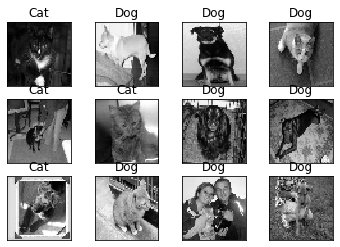

In [31]:
import matplotlib.pyplot as plt
# if you need to create the data:
test_data = process_test_data()
# if you already habe some saved:
test_data = np.load('test_data.npy')

fig = plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    # model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label = 'Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()    

In [33]:
with open('submission_file.csv', 'w') as f:
    f.write('id,label\n')
    
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|██████████| 12500/12500 [00:41<00:00, 300.25it/s]
